In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'plot_hist_read_count',
        root = '..',
    )

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_short = pd.read_csv(snakemake.input['short_rna_hist'])
df_short['data source'] = 'merged \n RNA-seq \n (gm12878)'

df_quantseq = pd.read_csv(snakemake.input['quantseq_hist'])
df_quantseq['data source'] = 'QuantSeq3 \n (gm12878)'

df_long_gm12 = pd.read_csv(snakemake.input['long_rna_gm12_hist'])
df_long_gm12['data source'] = 'LR-RNA-seq \n (gm12878)'

df_read3 = pd.read_csv(snakemake.input['read3'])
df_read3['data source'] = "3' READS \n (c2c12)"

df_long_c2c12 = pd.read_csv(snakemake.input['long_rna_c2c12_hist'])
df_long_c2c12['data source'] = "LR-RNA-seq \n (c2c12)"

In [4]:
df = pd.concat([
    df_quantseq,
    df_short,
    df_long_gm12,
    df_read3,
    df_long_c2c12
]).rename(columns={'dist': 'Distance to TES'})

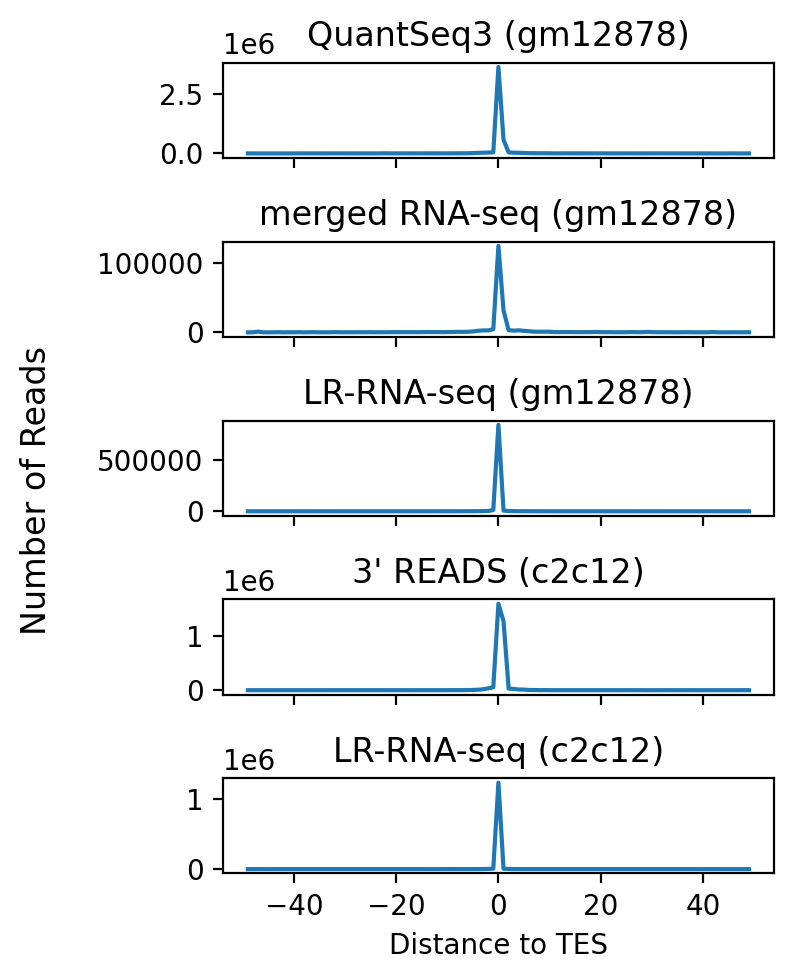

In [5]:
fig, axs = plt.subplots(5, figsize=(4, 5), dpi=200, sharex=True)

data_sources = df['data source'].unique()
for i, data_source in enumerate(data_sources):
    # plt.figure()

    axs[i].set_title(data_source.replace(' \n', ''))
    sns.lineplot(x='Distance to TES', y='Value', 
                 data=df[df['data source'] == data_source], 
                 ax=axs[i])
    axs[i].set_ylabel('')
    # axs[i].set_xlabel('')
    # if i != (len(data_sources) - 1):
   #      axs[i].set_xticks([])    

plt.subplots_adjust()
# plt.xlabel('Distance to TES')
fig.supylabel('Number of Reads')
plt.tight_layout()

plt.savefig(snakemake.output['hist'], bbox_inches = "tight")

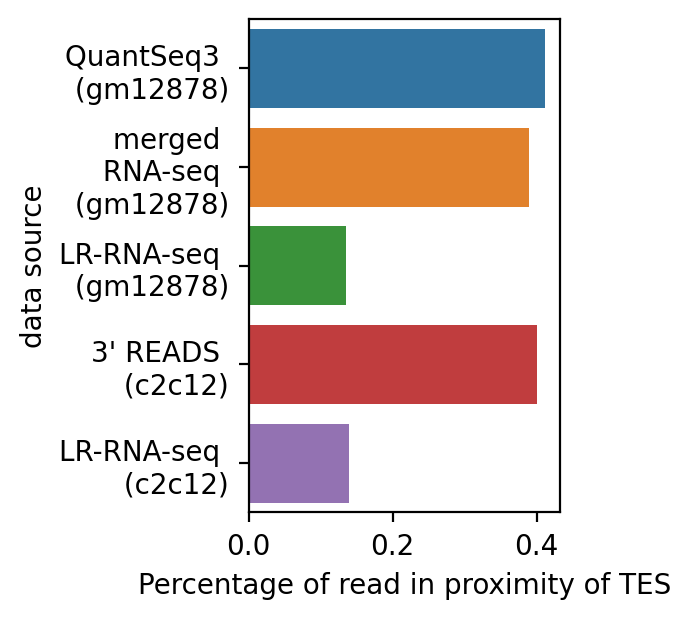

In [14]:
plt.figure(figsize=(3, 3.2), dpi=200)

rows = list()

with open(snakemake.input['quantseq_percent']) as f:
    rows.append({'data source': 'QuantSeq3 \n (gm12878)', 
                 'percentage': float(f.readline())})
    
with open(snakemake.input['short_rna_percent']) as f:
    rows.append({'data source':'merged \n RNA-seq \n (gm12878)', 
                 'percentage': float(f.readline())})

with open(snakemake.input['long_rna_gm12_percent']) as f:
    rows.append({'data source': 'LR-RNA-seq \n (gm12878)', 
                 'percentage': float(f.readline())})

with open(snakemake.input['read3_percent']) as f:
    rows.append({'data source': "3' READS \n (c2c12)", 
                 'percentage': float(f.readline())})

with open(snakemake.input['long_rna_c2c12_percent']) as f:
    rows.append({'data source': "LR-RNA-seq \n (c2c12)", 
                 'percentage': float(f.readline())})

ylabel = 'Percentage of read in proximity of TES'
df = pd.DataFrame(rows).rename(columns={'percentage': ylabel})
sns.barplot(data=df, y="data source", x=ylabel)

plt.tight_layout()
plt.savefig(snakemake.output['percent'], bbox_inches = "tight")